### 1) Initial Imports and loading the utils function. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.<br>Custom dataset and dataloader is implemented in <a href="https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k">this</a> notebook.

In [1]:
#location of the training data 
data_location =  ""
#copy dataloader
!cp ../input/data-loader/data_loader.py .

#imports
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

#custom imports 
from data_loader import FlickrDataset,get_data_loader
print(torch.cuda.mem_get_info())

'cp' is not recognized as an internal or external command,
operable program or batch file.
c:\Users\Eachann\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Eachann\AppData\Local\Programs\Python\Python39\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


(9548333056, 10736893952)


### 2) **<b>Implementing the Helper function to plot the Tensor image**

In [2]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#### Split train validation and test file. Only run once.

In [3]:
if 1:
    caption_file = data_location+"captions.txt"
    df = pd.read_csv(caption_file)
    df_size= df.shape[0]
    train_pos = int(df_size*0.6)
    val_pos = int(df_size*0.8)
    df_train = df.iloc[range(train_pos)]
    df_val = df.iloc[range(train_pos,val_pos)]
    df_test = df.iloc[range(val_pos,df_size)]
    with open('train.csv', 'w') as f:
        dfAsString = df_train.to_csv(header=True, index=False)
        f.write(dfAsString)
    with open('validation.csv', 'w') as f:
        dfAsString = df_val.to_csv(header=True, index=False)
        f.write(dfAsString)
    with open('test.csv', 'w') as f:
        dfAsString = df_test.to_csv(header=True, index=False)
        f.write(dfAsString)
print("df size",df_size)

df size 40455


In [4]:

#Initiate the Dataset and Dataloader
#setting the constants
data_location =  ""
BATCH_SIZE = 350
# BATCH_SIZE = 6
NUM_WORKER = 0

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"Images",
    caption_file = data_location+"captions.txt",
    transform=transforms
)
dataset_train =  FlickrDataset(
    root_dir = data_location+"Images",
    caption_file = data_location+"train.csv",
    transform=transforms
)
dataset_validation =  FlickrDataset(
    root_dir = data_location+"Images",
    caption_file = data_location+"validation.csv",
    transform=transforms
)
dataset_test =  FlickrDataset(
    root_dir = data_location+"Images",
    caption_file = data_location+"test.csv",
    transform=transforms
)

lengths = (torch.Tensor([0.6, 0.2, 0.2])*len(dataset)).int()
#dataset_train, dataset_validation, dataset_test = torch.utils.data.random_split(dataset = dataset, lengths = lengths)
#print('lens',dataset.imgs[0],dataset.imgs[1],dataset.captions[0])
#writing the dataloader
pad_idx = dataset.vocab.stoi["<PAD>"]
print("pad ind",pad_idx)
data_loader_train = get_data_loader(
    dataset=dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    padind = pad_idx
)
data_loader_val = get_data_loader(
    dataset=dataset_validation,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    padind = pad_idx
)
data_loader_test = get_data_loader(
    dataset=dataset_test,
    batch_size=1,
    num_workers=NUM_WORKER,
    shuffle=True,
    padind = pad_idx
)
#vocab_size
#vocab_size = len(dataset_train.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

pad ind 0


device(type='cuda', index=0)

### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [7]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [8]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [9]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


### 4) Setting Hypperparameter and Init the model

In [10]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [11]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [13]:
avail = torch.cuda.memory_allocated()/1e9
print(avail)
print(torch.cuda.mem_get_info())

0.143807488
(9382658048, 10736893952)


In [14]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.
def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

## 5) Training Job from above configs

 97%|█████████▋| 68/70 [02:01<00:03,  1.77s/it]

Epoch: 1 loss: 4.36777


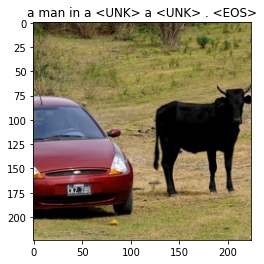

 99%|█████████▊| 69/70 [02:40<00:12, 12.82s/it]

tot loss 151.81207704544067 24 6.325503210226695


 97%|█████████▋| 68/70 [01:57<00:03,  1.66s/it]

Epoch: 2 loss: 3.94073


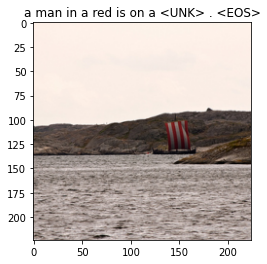

 99%|█████████▊| 69/70 [02:34<00:12, 12.40s/it]

tot loss 163.20053052902222 24 6.800022105375926


 97%|█████████▋| 68/70 [01:53<00:03,  1.66s/it]

Epoch: 3 loss: 3.57320


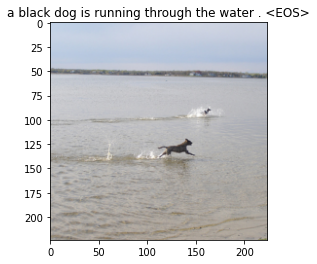

 99%|█████████▊| 69/70 [02:30<00:12, 12.32s/it]

tot loss 172.5418839454651 24 7.189245164394379


 97%|█████████▋| 68/70 [01:55<00:03,  1.80s/it]

Epoch: 4 loss: 3.27147


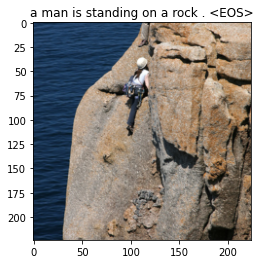

 99%|█████████▊| 69/70 [02:34<00:12, 13.00s/it]

tot loss 178.91481065750122 24 7.4547837773958845


 97%|█████████▋| 68/70 [01:55<00:03,  1.66s/it]

Epoch: 5 loss: 3.24140


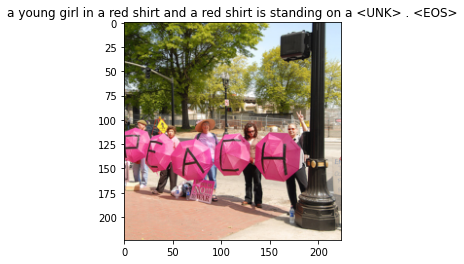

 99%|█████████▊| 69/70 [02:32<00:12, 12.52s/it]

tot loss 184.45730781555176 24 7.685721158981323


 97%|█████████▋| 68/70 [01:53<00:03,  1.68s/it]

Epoch: 6 loss: 3.15433


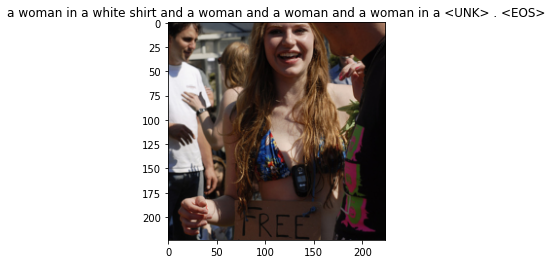

 99%|█████████▊| 69/70 [02:31<00:12, 12.34s/it]

tot loss 189.06060409545898 24 7.877525170644124


 97%|█████████▋| 68/70 [01:53<00:03,  1.70s/it]

Epoch: 7 loss: 3.02954


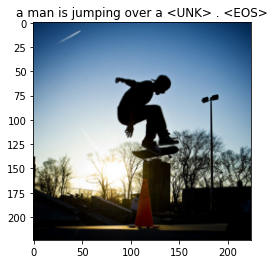

 99%|█████████▊| 69/70 [02:31<00:12, 12.41s/it]

tot loss 193.10917377471924 24 8.046215573946634


 97%|█████████▋| 68/70 [01:53<00:03,  1.66s/it]

Epoch: 8 loss: 2.96611


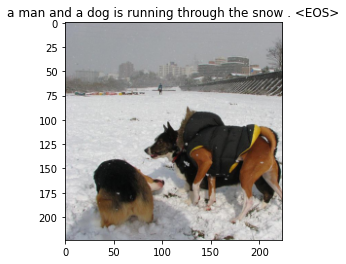

 99%|█████████▊| 69/70 [02:31<00:12, 12.44s/it]

tot loss 195.750319480896 24 8.156263311704


 97%|█████████▋| 68/70 [01:56<00:03,  1.75s/it]

Epoch: 9 loss: 2.86576


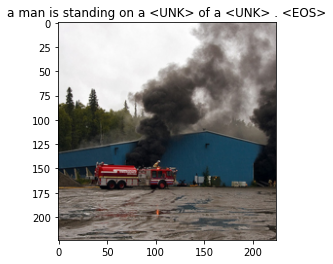

 99%|█████████▊| 69/70 [02:35<00:12, 12.94s/it]

tot loss 199.1654510498047 24 8.29856046040853


 97%|█████████▋| 68/70 [01:59<00:03,  1.81s/it]

Epoch: 10 loss: 2.82022


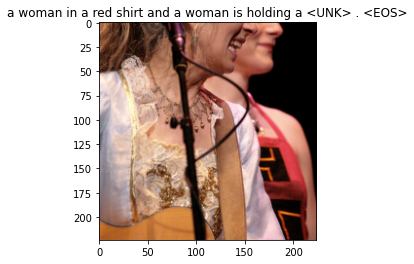

 99%|█████████▊| 69/70 [02:38<00:13, 13.02s/it]

tot loss 201.99821281433105 24 8.416592200597128


 97%|█████████▋| 68/70 [01:57<00:03,  1.62s/it]

Epoch: 11 loss: 2.74158


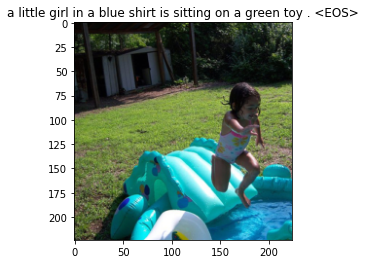

 99%|█████████▊| 69/70 [02:33<00:12, 12.07s/it]

tot loss 204.6659116744995 24 8.527746319770813


 97%|█████████▋| 68/70 [01:53<00:03,  1.68s/it]

Epoch: 12 loss: 2.67897


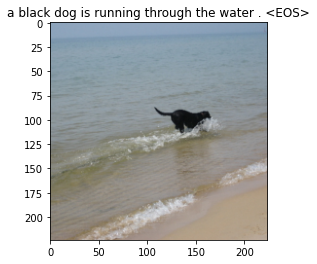

 99%|█████████▊| 69/70 [02:31<00:12, 12.36s/it]

tot loss 205.50390625 24 8.562662760416666


 97%|█████████▋| 68/70 [01:52<00:03,  1.64s/it]

Epoch: 13 loss: 2.63742


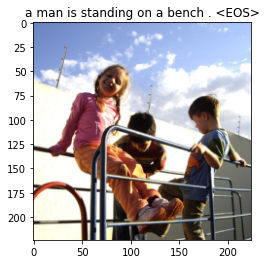

 99%|█████████▊| 69/70 [02:29<00:12, 12.27s/it]

tot loss 208.6284475326538 24 8.692851980527243


 97%|█████████▋| 68/70 [01:53<00:03,  1.69s/it]

Epoch: 14 loss: 2.59604


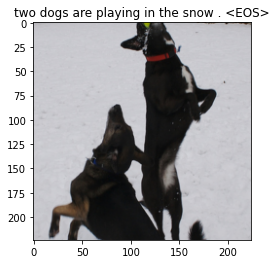

 99%|█████████▊| 69/70 [02:30<00:12, 12.41s/it]

tot loss 210.93260192871094 24 8.788858413696289


 97%|█████████▋| 68/70 [01:58<00:03,  1.76s/it]

Epoch: 15 loss: 2.55650


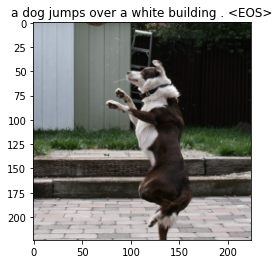

 99%|█████████▊| 69/70 [02:37<00:13, 13.10s/it]

tot loss 212.34253978729248 24 8.84760582447052


 97%|█████████▋| 68/70 [01:59<00:03,  1.72s/it]

Epoch: 16 loss: 2.58536


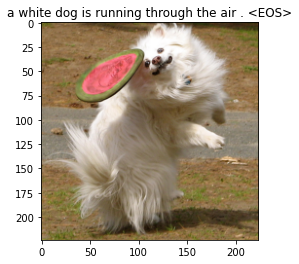

 99%|█████████▊| 69/70 [02:38<00:12, 12.84s/it]

tot loss 215.16675853729248 24 8.96528160572052


 97%|█████████▋| 68/70 [01:58<00:03,  1.76s/it]

Epoch: 17 loss: 2.47105


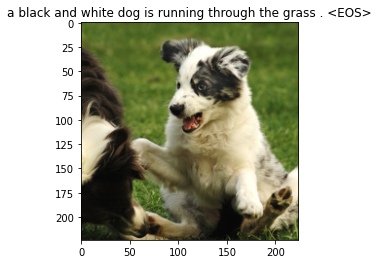

 99%|█████████▊| 69/70 [02:38<00:13, 13.06s/it]

tot loss 215.94004821777344 24 8.997502009073893


 97%|█████████▋| 68/70 [01:59<00:03,  1.73s/it]

Epoch: 18 loss: 2.42024


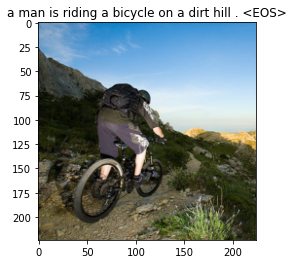

 99%|█████████▊| 69/70 [02:38<00:13, 13.02s/it]

tot loss 215.72403812408447 24 8.988501588503519


 97%|█████████▋| 68/70 [01:59<00:03,  1.79s/it]

Epoch: 19 loss: 2.39774


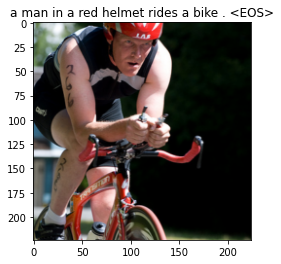

 99%|█████████▊| 69/70 [02:38<00:12, 12.97s/it]

tot loss 217.78819942474365 24 9.074508309364319


 97%|█████████▋| 68/70 [01:58<00:03,  1.74s/it]

Epoch: 20 loss: 2.29732


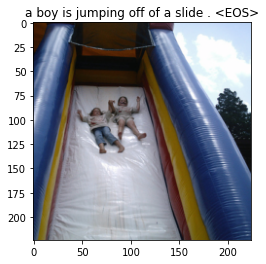

 99%|█████████▊| 69/70 [02:37<00:12, 12.93s/it]

tot loss 219.90058040618896 24 9.162524183591207


100%|██████████| 70/70 [02:38<00:00,  2.26s/it]


In [15]:
num_epochs = 20
print_every = 69
from tqdm import tqdm
torch.cuda.empty_cache()
losses = []
valid_loss = []
valid_bleu1 = []
valid_bleu4 = []
for epoch in (range(1,num_epochs+1)):   
    for idx, (image, captions) in enumerate(tqdm(iter(data_loader_train))):
        image,captions = image.to(device),captions.to(device)
        #print(torch.cuda.mem_get_info())

        # Zero the gradients.
        optimizer.zero_grad()
        #print(torch.cuda.mem_get_info())
        # Feed forward
        outputs,attentions = model(image, captions)
        #print(torch.cuda.mem_get_info())
        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        losses += [loss.item()]
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            #generate the caption
            model.eval()
            loss_avg = 0
            bleu1_avg = 0
            bleu4_avg = 0
            with torch.no_grad():
                dataiter = iter(data_loader_test)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                for idx, (imgs, caps) in enumerate(tqdm(data_loader_val)):
                    imgs, caps = imgs.to(device), caps.to(device)
                    out,_ = model(imgs, caps)
                    caps = caps[:,:-1]
                    loss_avg += criterion(out.view(-1, vocab_size) , caps.reshape(-1)).item()
                    #pred = out
                    #ref_text = [[dataset.vocab.itos[symbol] for symbol in token] for token in caps.squeeze(0).cpu().numpy()]
                    #pr = np.argmax(pred.cpu().numpy(),axis = 2)
                    #pred_text = [[dataset.vocab.itos[symbol] for symbol in token] for token in pr]
                    #bleu1_avg += sum([bleu1([ref_text[i]], pred_text[i]) for i in range(pr.shape[0])])
                    #bleu4_avg += sum([bleu4([ref_text[i]], pred_text[i]) for i in range(pr.shape[0])])
            print("tot loss",loss_avg, idx+1, loss_avg /(idx+1))
            loss_avg /= idx+1
            valid_loss.append(loss_avg)
            #valid_bleu1.append(bleu1_avg)
            #valid_bleu4.append(bleu4_avg)
            model.train()
    #save the latest model
    save_model(model,epoch)
losses = np.array(losses)
np.save('loss.npy',losses)
valid_loss = np.array(valid_loss)
np.save('loss_val.npy',valid_loss)

In [29]:
#print(len(ref_text),pr.shape)
#bleu1_avg += [bleu1([ref_text[i]], pred_text[i]) for i in range(BATCH_SIZE)]

NameError: name 'ref_text' is not defined

In [31]:
torch.cuda.empty_cache()
#out.reshape(-1, vocab_size)
#loss_avg += criterion(out.reshape(-1, vocab_size) , caps.reshape(-1)).item()
#print(out.shape,outputs.shape,targets.shape,caps.shape,vocab_size)
#criterion(out.view(-1, vocab_size) , caps.reshape(-1)).item()
#print(out.view(-1, vocab_size).shape,outputs.view(-1, vocab_size).shape,caps.view(-1).shape)

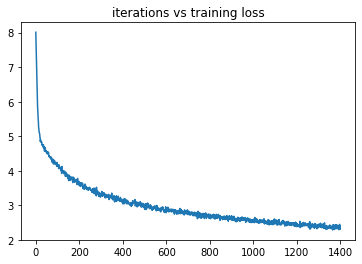

In [32]:
plt.plot(losses)
plt.title('iterations vs training loss')
plt.show()


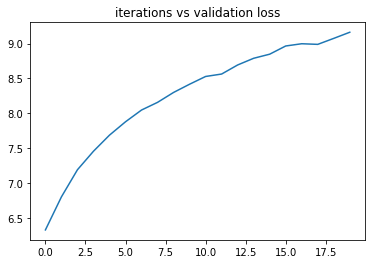

In [33]:
plt.plot(valid_loss)
plt.title('iterations vs validation loss')
plt.show()

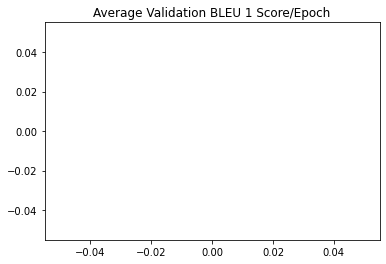

[]


In [34]:
plt.plot(valid_bleu1)
plt.title('Average Validation BLEU 1 Score/Epoch')
plt.show()
print(valid_bleu1)

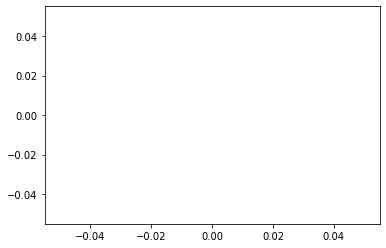

In [35]:
plt.plot(valid_bleu4)

In [36]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

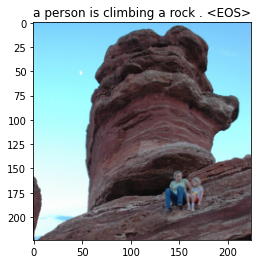

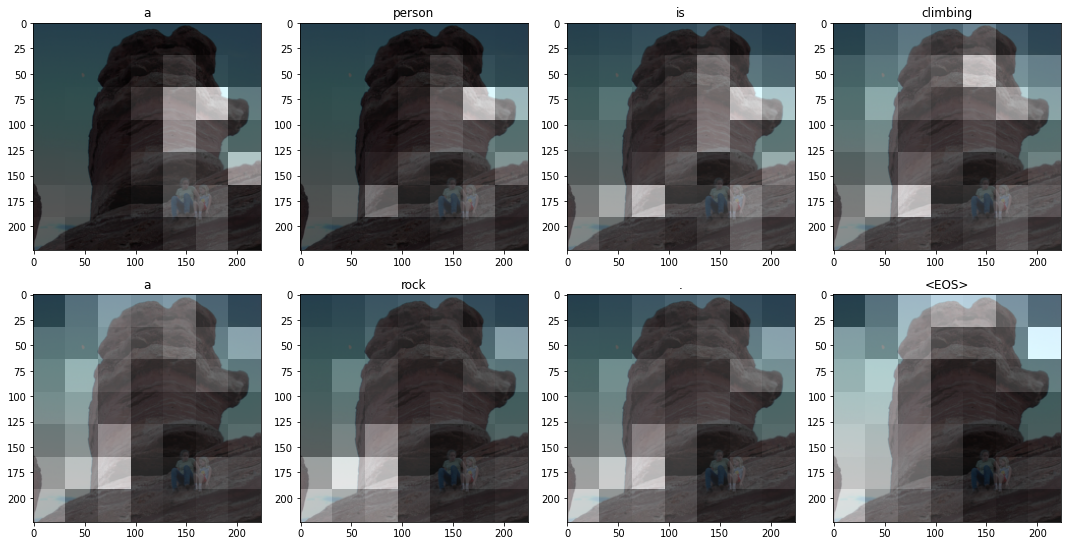

In [37]:
#show any 1
dataiter = iter(data_loader_test)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

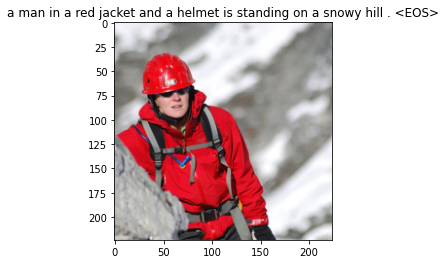

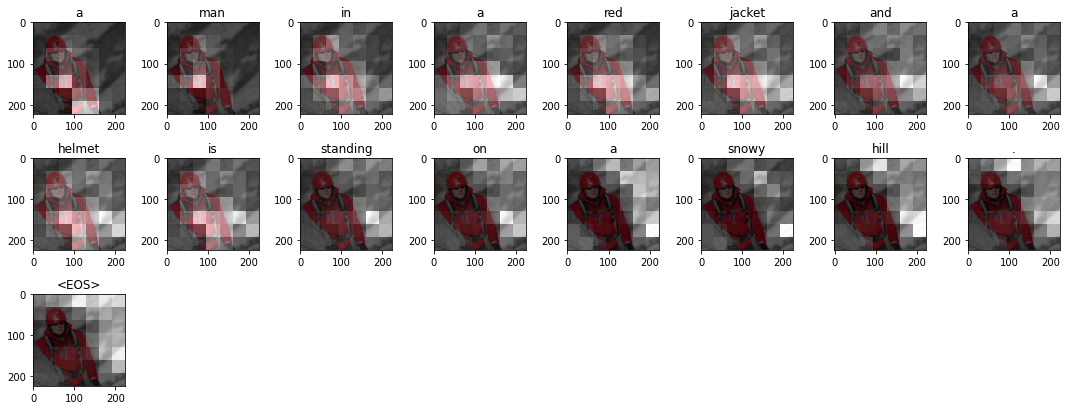

In [39]:
#show any 1
dataiter = iter(data_loader_test)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

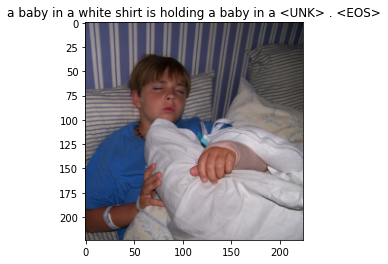

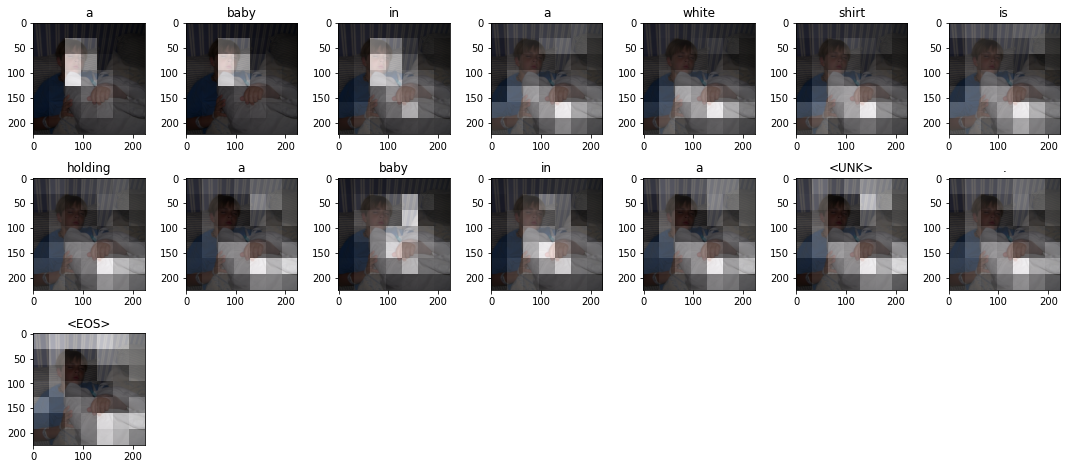

In [41]:
#show any 1
dataiter = iter(data_loader_test)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [43]:
#show any 1
dataiter = iter(data_loader_test)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

NameError: name 'data_loader' is not defined

In [ ]:
bleu1_avg = 0
bleu4_avg = 0
model.eval()
flickr_dataset= dataset
with torch.no_grad():
    for idx, (imgs, caps) in enumerate(tqdm(data_loader_test)):
        output,_ = model(imgs.to(device),caps.to(device))
        out = np.argmax(output.cpu().numpy(),axis = 2)
        ref_text = [[flickr_dataset.vocab.itos[int(sym)] for sym in token] for token in caps.cpu().squeeze(0).numpy()]
        pred_text = [[flickr_dataset.vocab.itos[int(sym)] for sym in token] for token in out]
        print(ref_text[0])
        print( pred_text[0])
        bleu1_avg += bleu1([ref_text], pred_text)
        bleu4_avg += bleu4([ref_text], pred_text)


        if (idx+1)%400 == 0:
            show_image(imgs[0])
            print("Prediction:")
            print(' '.join(pred_text))
            print("Reference:")
            print(" ".join(ref_text))
            print("BLEU1:")
            print(bleu1([ref_text], pred_text))

bleu1_avg /= (idx+1)
bleu4_avg /= (idx+1)

  0%|          | 0/24 [00:01<?, ?it/s]

['<SOS>', 'a', 'dogs', '<UNK>', 'near', 'mouse', 'mouth', 'of', 'sand', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['a', 'man', 'in', 'in', 'a', 'a', '.', 'a', '.', '<EOS>', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


TypeError: unhashable type: 'list'

 12%|█▏        | 998/8091 [00:19<02:20, 50.42it/s]

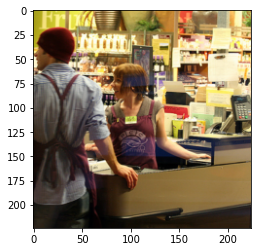

 12%|█▏        | 1010/8091 [00:19<02:45, 42.90it/s]

Prediction:
a people <UNK> <UNK> woman <UNK> in <EOS>
Reference:
<SOS> little umbrellas , a row new . <EOS>
BLEU1:
22.062422564614888
BLEU4:
1.764993805169191


 25%|██▍       | 1998/8091 [00:39<02:01, 50.21it/s]

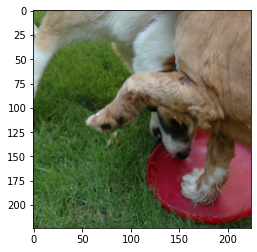

 25%|██▍       | 2004/8091 [00:40<02:37, 38.65it/s]

Prediction:
a dog and dogs through a a . . a . . . a . <EOS>
Reference:
<SOS> little street beads running lone of <UNK> fishing for rock meal night of rocky . <EOS>
BLEU1:
11.742663285168451
BLEU4:
0.7226254329334431


 37%|███▋      | 2997/8091 [00:59<01:43, 49.26it/s]

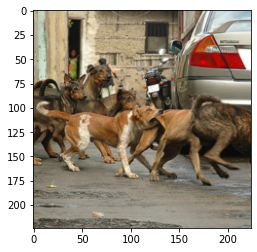

 37%|███▋      | 3008/8091 [01:00<02:04, 40.95it/s]

Prediction:
a dogs and a in on . . . <UNK> . in a a . <EOS>
Reference:
<SOS> hockey street taking girl it little street <UNK> a mask man with of <UNK> . <EOS>
BLEU1:
23.485326570336895
BLEU4:
0.7226254329334431


 49%|████▉     | 3996/8091 [01:19<01:19, 51.66it/s]

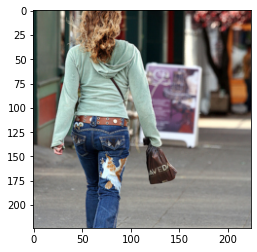

 50%|████▉     | 4008/8091 [01:20<01:33, 43.46it/s]

Prediction:
a woman in in a the . . . . . . a . . <EOS>
Reference:
<SOS> painting train trail of into <UNK> baby dog <UNK> rope night of <UNK> new . <EOS>
BLEU1:
11.742663285168451
BLEU4:
0.7226254329334431


 62%|██████▏   | 4998/8091 [01:40<01:00, 51.02it/s]

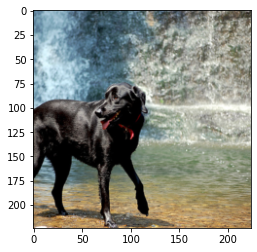

 62%|██████▏   | 5009/8091 [01:40<01:13, 42.11it/s]

Prediction:
a black and running in in a a water dog <EOS>
Reference:
<SOS> of men is man bench boys with of white . <EOS>
BLEU1:
8.300915602566022
BLEU4:
1.1413758953528286


 74%|███████▍  | 5998/8091 [02:00<00:43, 47.76it/s]

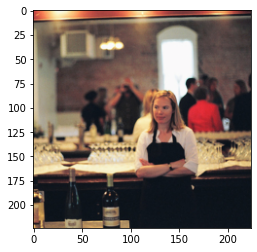

 74%|███████▍  | 6008/8091 [02:00<00:50, 40.88it/s]

Prediction:
a people <UNK> a a a <UNK> <UNK> <UNK> . <UNK> <UNK> . <EOS>
Reference:
<SOS> of <UNK> with on with grassy the of performs , a gym . <EOS>
BLEU1:
26.601793705829223
BLEU4:
0.8464207088218394


 86%|████████▋ | 6995/8091 [02:20<00:23, 47.09it/s]

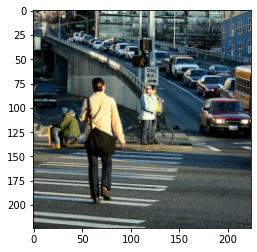

 87%|████████▋ | 7005/8091 [02:20<00:27, 39.70it/s]

Prediction:
a man man is man and a in a <UNK> <EOS>
Reference:
<SOS> a big scarf a stump takes girl of skinny . <EOS>
BLEU1:
24.902746807698065
BLEU4:
1.1413758953528286


 99%|█████████▉| 7997/8091 [02:40<00:01, 50.27it/s]

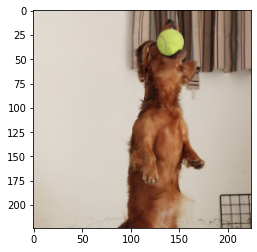

 99%|█████████▉| 8009/8091 [02:40<00:01, 44.63it/s]

Prediction:
a dog dog is a and ball to a . and <EOS>
Reference:
<SOS> a orange man from hat a next with toy green . <EOS>
BLEU1:
30.668147154310777
BLEU4:
1.0222715718103592


100%|██████████| 8091/8091 [02:42<00:00, 49.80it/s]

26.747080532444052
1.0911054754688616


In [ ]:
bleu1_avg = 0
bleu4_avg = 0
model.eval()
data_loader_test = get_data_loader(
    dataset=dataset_test,
    batch_size=1,
    num_workers=NUM_WORKER,
    shuffle=True,
    padind = pad_idx
)
with torch.no_grad():
    for idx, (imgs, caps) in enumerate(tqdm(data_loader_test)):
        output,_ = model(imgs.to(device),caps.to(device))
        caps = caps.squeeze()#[None, :]
        imgs  = imgs.squeeze()#[None, :]
        out = np.argmax(output.cpu().numpy(),axis = 2)[0]
        #print([token for token in out])
        ref_text = [flickr_dataset.vocab.itos[int(token)] for token in caps.cpu().squeeze(0).numpy()]
        pred_text = [flickr_dataset.vocab.itos[int(token)] for token in out]

        bleu1_avg += bleu1([ref_text], pred_text)
        bleu4_avg += bleu4([ref_text], pred_text)


        if (idx+1)%1000 == 0:
            show_image(imgs)
            print("Prediction:")
            print(' '.join(pred_text))
            print("Reference:")
            print(" ".join(ref_text))
            print("BLEU1:")
            print(bleu1([ref_text], pred_text))
            print("BLEU4:")
            print(bleu4([ref_text], pred_text))

bleu1_avg /= (idx+1)
bleu4_avg /= (idx+1)
print(bleu1_avg)
print(bleu4_avg)